# Data Collection & Preprocessing

## Overview
This notebook downloads and preprocesses Amazon 2023 product review data from McAuley Lab. It handles downloading raw CSV files, converting to Parquet format, creating stratified samples, and processing metadata. The pipeline ensures data consistency across train/validation/test splits while maintaining the 5-core property (each user and item has at least 5 interactions).

## Notebook Structure
1. **Setup**: Import libraries, configure paths, and define constants
2. **Download Functions**: Fetch raw data from URLs with retry logic
3. **Conversion**: Transform CSV.GZ to Parquet for efficient storage
4. **Sampling**: Create stratified samples (small/medium/large/big) maintaining user-item distributions
5. **Metadata Processing**: Download and extract essential product information (title, features, description, etc.)
6. **Pipeline**: Automated execution for all categories

## Process Flow
**Data Collection:**
- For each category: Download train/valid/test CSV.GZ from McAuley Lab → Convert to Parquet
- Download metadata JSONL.GZ → Extract essential fields → Save as Parquet

**Sampling:**
- Create samples from full dataset: small (2k users), medium (20k), large (50k), big (50k with item filtering)
- For train: Sample top N active users → Filter items by popularity threshold
- For valid/test: Filter to match train users and items for consistency

**Output:**
- Full datasets: `category.5core.{split}.parquet`
- Samples: `category.5core.{split}.{size}.parquet`
- Metadata: `category.meta.parquet`

In [2]:
import sys, os, json, gzip, urllib.request
from pathlib import Path
import pandas as pd
import polars as pl
import numpy as np

module_path = str((Path("..") / "utilities").resolve())
if module_path not in sys.path:
    sys.path.append(module_path)

from logger import Logger
from configurations import Configurations

logger = Logger(process_name="data_collection", log_file=Configurations.LOG_PATH)

RAW_DIR = Path(Configurations.DATA_RAW_PATH)
RAW_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_DIR = Path(Configurations.DATA_PROCESSED_PATH)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

CATEGORIES = Configurations.CATEGORIES
CORES = Configurations.CORES
SPLITS = Configurations.SPLITS
BASE_URL = Configurations.BASE_URL
meta_base_url = "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_{category}.jsonl.gz"
meta_urls = {cat: meta_base_url.format(category=cat) for cat in CATEGORIES}

In [3]:
def build_url(core: str, category: str, split: str) -> str:
    return f"{BASE_URL}/{core}/last_out_w_his/{category}.{split}.csv.gz"

def local_path_for_parquet(core: str, category: str, split: str, sample: str = None, raw_dir=RAW_DIR) -> Path:
    safe_cat = category.replace("/", "-")
    if raw_dir == RAW_DIR:
        return RAW_DIR / f"{safe_cat}.{core}.{split}.csv.gz"
    elif raw_dir == PROCESSED_DIR:
        if sample is None:
            return PROCESSED_DIR / f"{safe_cat}.{core}.{split}.parquet"
        else:
            return PROCESSED_DIR / f"{safe_cat}.{core}.{split}.{sample}.parquet"
    else:
        raise ValueError(f"Invalid directory: {raw_dir}")

def download_file(url: str, out_path: Path, max_retries: int = 3) -> None:
    if out_path.exists() and out_path.stat().st_size > 0:
        logger.log_info(f"Exists, skip: {out_path.name}")
        return
    attempt = 0
    while attempt < max_retries:
        try:
            attempt += 1
            logger.log_info(f"Downloading (attempt {attempt}/{max_retries}): {url}")
            tmp = str(out_path) + ".part"
            urllib.request.urlretrieve(url, tmp)
            os.replace(tmp, out_path)
            logger.log_info(f"Saved: {out_path.name}")
            return
        except Exception as e:
            logger.log_warning(f"Failed attempt {attempt} for {url}: {e}")
    raise RuntimeError(f"Exceeded retries: {url}")

def save_dataset_to_parquet(csv_gz_path: Path, out_parquet_path: Path):
    if out_parquet_path.exists():
        logger.log_info(f"Skip: {out_parquet_path.name}")
        return
    logger.log_info(f"Reading: {csv_gz_path.name}")
    df = pl.from_pandas(pd.read_csv(csv_gz_path, compression='gzip')[Configurations.COLUMNS])
    logger.log_info(f"  Shape: {df.shape}")
    logger.log_info(f"  Users: {df['user_id'].n_unique():,}")
    logger.log_info(f"  Items: {df['parent_asin'].n_unique():,}")
    df.to_pandas().to_parquet(out_parquet_path, engine='pyarrow', index=False)
    logger.log_info(f"Saved: {out_parquet_path.name}\n")

In [4]:
def create_n_sample(input_path: Path, n: int, item_mult: float = 1.0, n_name_out: str = None):
    stem = input_path.stem
    parts = stem.split('.')
    category, core, split = parts[0], parts[1] if len(parts) > 1 else '5core', parts[2] if len(parts) > 2 else 'train'
    output_path = input_path.parent / f"{category}.{core}.{split}.{n_name_out}.parquet"
    
    if output_path.exists():
        logger.log_info(f"Skip: {output_path.name}")
        return
    
    if category == "Electronics":
        item_mult = item_mult * 1.82
        logger.log_info(f"Category Electronics detected: item_mult adjusted to {item_mult}")

    if category == "Sports_and_Outdoors":
        item_mult = item_mult * 0.7
        logger.log_info(f"Category Sports_and_Outdoors detected: item_mult adjusted to {item_mult}")

    logger.log_info(f"\nSampling {n} users")
    logger.log_info(f"  Input:  {input_path.name}")
    logger.log_info(f"  Output: {output_path.name}")
    
    df = pl.read_parquet(input_path)
    total = df['user_id'].n_unique()
    logger.log_info(f"  Total users: {total:,}")
    
    if split == 'train':
        if n >= total:
            df_sampled = df
            users_n = df['user_id'].unique().to_list()
        else:
            activity = df.group_by('user_id').agg(pl.len().alias('n')).sort('n', descending=True)
            users_n = activity.head(n)['user_id'].to_list()
            df_sampled = df.filter(pl.col('user_id').is_in(users_n))
        
        if item_mult > 1.0:
            logger.log_info(f"  Before item filter: {df_sampled.shape} shape, {len(df_sampled):,} ratings, {df_sampled['user_id'].n_unique():,}  users, {df_sampled['parent_asin'].n_unique():,} items")
            item_counts = df_sampled.group_by('parent_asin').agg(pl.len().alias('n'))
            avg_item = item_counts['n'].mean()
            min_item = avg_item * item_mult
            logger.log_info(f"  Avg ratings/item: {avg_item:.2f}")
            logger.log_info(f"  Min threshold: {min_item:.2f} ({item_mult}x avg)")
            popular = item_counts.filter(pl.col('n') > min_item)['parent_asin'].to_list()
            df_sampled = df_sampled.filter(pl.col('parent_asin').is_in(popular))
            logger.log_info(f"  After item filter: {df_sampled.shape} shape, {len(df_sampled):,} ratings, {df_sampled['user_id'].n_unique():,}  users, {df_sampled['parent_asin'].n_unique():,} items")
        
        logger.log_info(f"  Sampled: {df_sampled.shape} shape, {len(df_sampled):,} ratings, {len(users_n):,} users")
    else:
        train_path = input_path.parent / f"{category}.{core}.train.{n_name_out}.parquet"
        if not train_path.exists():
            logger.log_warning(f"  Train sample not found: {train_path.name}")
            return
        df_train = pl.read_parquet(train_path)
        users_n = df_train['user_id'].unique().to_list()
        items_n = df_train['parent_asin'].unique().to_list()
        df_sampled = df.filter(pl.col('user_id').is_in(users_n) & pl.col('parent_asin').is_in(items_n))
        logger.log_info(f"  Filtered: {len(df_sampled):,} ratings, {df_sampled['user_id'].n_unique():,} users")
    
    df_sampled.to_pandas().to_parquet(output_path, engine='pyarrow', index=False)
    logger.log_info(f"  Saved: {output_path.name}\n")

In [5]:
def download_meta(category: str, url: str = None):
    url = url or meta_urls.get(category)
    if not url:
        return
    dst = RAW_DIR / f"{category}.meta.jsonl.gz"
    if dst.exists() and dst.stat().st_size > 0:
        logger.log_info(f"[META] Skip: {dst.name}")
        return
    logger.log_info(f"[META] Downloading: {category}")
    try:
        urllib.request.urlretrieve(url, str(dst))
        logger.log_info(f"[META] {dst.name}")
    except Exception as e:
        logger.log_exception(f"[META] Failed: {e}")

def save_meta_for_training_ui(category: str):
    safe_cat = category.replace('/', '-')
    out_path = PROCESSED_DIR / f"{safe_cat}.meta.parquet"
    
    if out_path.exists():
        logger.log_info(f"[META] Skip: {out_path.name}")
        return out_path
    
    fp = RAW_DIR / f"{category}.meta.jsonl.gz"
    if not fp.exists():
        logger.log_warning(f"[META] Not found: {fp}")
        return None
    
    logger.log_info(f"[META] Reading: {fp.name}")
    
    def extract_item(obj):
        def process_list(field, max_items):
            if not isinstance(field, list):
                return []
            if field and isinstance(field[0], list):
                field = field[0]
            return field[:max_items]
        
        def process_desc(desc, max_len=2000):
            if isinstance(desc, list):
                desc = " ".join(str(d) for d in desc if d)
            elif not desc:
                return ""
            else:
                desc = str(desc)
            return desc[:max_len] + ("..." if len(desc) > max_len else "")
        
        def process_images(img_list):
            if not img_list or not isinstance(img_list, list):
                return []
            return [{"hi_res": img.get("hi_res"), "thumb": img.get("thumb")} 
                    for img in img_list[:3] if isinstance(img, dict)]
        
        return {
            "parent_asin": obj.get("parent_asin"),
            "title": obj.get("title", ""),
            "price": obj.get("price"),
            "average_rating": obj.get("average_rating"),
            "rating_number": obj.get("rating_number"),
            "features": process_list(obj.get("features"), 10),
            "description": process_desc(obj.get("description")),
            "categories": process_list(obj.get("categories"), 5),
            "images": process_images(obj.get("images")),
            "store": obj.get("store", "")
        }
    
    rows = []
    with gzip.open(fp, "rt", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                if obj.get("parent_asin"):
                    rows.append(extract_item(obj))
            except:
                continue
    
    if not rows:
        logger.log_warning(f"[META] No data for {category}")
        return None
    
    df = pd.DataFrame(rows)
    for col in ['price', 'average_rating', 'rating_number']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    for col in ['title', 'description', 'store']:
        df[col] = df[col].fillna('')
    
    df.to_parquet(out_path, index=False)
    logger.log_info(f"[META] {out_path.name}: {len(df):,} items")
    return out_path

In [6]:
def run():
    logger.log_info("="*70)
    logger.log_info("DATASET COLLECTION")
    logger.log_info("="*70 + "\n")

    for core in CORES:
        for cat in CATEGORIES:
            logger.log_info(f"\n{'='*70}")
            logger.log_info(f"{cat}")
            logger.log_info(f"{'='*70}")
            
            for split in SPLITS:
                logger.log_info(f"\nProcessing {split.upper()}...")
                url = build_url(core, cat, split)
                in_path = local_path_for_parquet(core, cat, split, raw_dir=RAW_DIR)
                out_path = local_path_for_parquet(core, cat, split, raw_dir=PROCESSED_DIR)
                try:
                    download_file(url, in_path)
                    save_dataset_to_parquet(in_path, out_path)
                except Exception as e:
                    logger.log_exception(f"{split} error: {e}")

    logger.log_info("\n" + "="*70)
    logger.log_info("METADATA")
    logger.log_info("="*70)
    
    for cat in CATEGORIES:
        download_meta(cat)
        save_meta_for_training_ui(cat)

    logger.log_info("\n" + "="*70)
    logger.log_info("CREATING SAMPLES")
    logger.log_info("="*70)
    
    for core in CORES:
        for cat in CATEGORIES:
            for split in SPLITS:
                for sample in Configurations.SAMPLE_SIZES:
                    if sample != "full":
                        n = Configurations.SAMPLE_SIZES[sample]
                        logger.log_info(f"\ncat={cat} - split={split} - sample={sample} - n={n} sampling...")
                        in_path = local_path_for_parquet(core, cat, split, raw_dir=PROCESSED_DIR)
                        out_path = local_path_for_parquet(core, cat, split, sample, raw_dir=PROCESSED_DIR)
                        logger.log_info(f"Input: {in_path.name} \n → Output: {out_path.name}")
                        create_n_sample(in_path, n, Configurations.ITEM_MULTI, sample)

    logger.log_info("\n COMPLETED")

In [7]:
run()

2025-11-03 15:04:00,747 - INFO - ======================================================================
2025-11-03 15:04:00,748 - INFO - DATASET COLLECTION
2025-11-03 15:04:00,749 - INFO - ======================================================================

2025-11-03 15:04:00,750 - INFO - 
2025-11-03 15:04:00,750 - INFO - Electronics
2025-11-03 15:04:00,751 - INFO - ======================================================================
2025-11-03 15:04:00,751 - INFO - 
Processing TRAIN...
2025-11-03 15:04:00,752 - INFO - Exists, skip: Electronics.5core.train.csv.gz
2025-11-03 15:04:00,757 - INFO - Skip: Electronics.5core.train.parquet
2025-11-03 15:04:00,759 - INFO - 
Processing VALID...
2025-11-03 15:04:00,792 - INFO - Exists, skip: Electronics.5core.valid.csv.gz
2025-11-03 15:04:00,793 - INFO - Skip: Electronics.5core.valid.parquet
2025-11-03 15:04:00,793 - INFO - 
Processing TEST...
2025-11-03 15:04:00,794 - INFO - Exists, skip: Electronics.5core.test.csv.gz
2025-11-03 15:04:00,

In [8]:
def diagnose_dataset(category: str, suffix: str = 'small'):
    safe_cat = category.replace('/', '-')
    logger.log_info("="*70)
    logger.log_info(f"DIAGNOSTIC: {category} (suffix={suffix})")
    logger.log_info("="*70)
    
    train = PROCESSED_DIR / f"{safe_cat}.5core.train.{suffix}.parquet"
    valid = PROCESSED_DIR / f"{safe_cat}.5core.valid.{suffix}.parquet"
    test = PROCESSED_DIR / f"{safe_cat}.5core.test.{suffix}.parquet"
    
    if not train.exists():
        logger.log_error(f"File not found: {train.name}")
        return
    
    df_train = pl.read_parquet(train)
    df_valid = pl.read_parquet(valid) if valid.exists() else None
    df_test = pl.read_parquet(test) if test.exists() else None
    
    def stats(df, name):
        u, i, r = df['user_id'].n_unique(), df['parent_asin'].n_unique(), len(df)
        s = 1 - (r / (u * i))
        logger.log_info(f"{name}: {r:,} ratings, {u:,} users, sparsity {s:.2%}")
        return u, i, r
    
    train_u, train_i, train_r = stats(df_train, "TRAIN")
    
    if df_valid is not None:
        valid_u, valid_i, valid_r = stats(df_valid, "VALID")
        train_users = set(df_train['user_id'].unique())
        valid_users = set(df_valid['user_id'].unique())
        train_items = set(df_train['parent_asin'].unique())
        valid_items = set(df_valid['parent_asin'].unique())
        user_overlap = len(train_users & valid_users)
        item_overlap = len(train_items & valid_items)
        logger.log_info(f"\nOVERLAP:")
        logger.log_info(f"  Users: {user_overlap:,} / {valid_u:,} ({user_overlap/valid_u*100:.1f}%)")
        logger.log_info(f"  Items: {item_overlap:,} / {valid_i:,} ({item_overlap/valid_i*100:.1f}%)")
        if user_overlap < valid_u:
            logger.log_warning(f"  {valid_u - user_overlap:,} valid users NOT in train!")
        if item_overlap < valid_i:
            logger.log_warning(f"  {valid_i - item_overlap:,} valid items NOT in train!")
    
    if df_test is not None:
        stats(df_test, "TEST")
    
    logger.log_info("="*70 + "\n")

In [9]:
for cat in Configurations.CATEGORIES:
    diagnose_dataset(cat, "big")

2025-11-03 15:04:00,837 - INFO - ======================================================================
2025-11-03 15:04:00,838 - INFO - DIAGNOSTIC: Electronics (suffix=big)
2025-11-03 15:04:00,839 - INFO - ======================================================================
2025-11-03 15:04:00,897 - INFO - TRAIN: 51,914 ratings, 32,556 users, sparsity 94.30%
2025-11-03 15:04:00,898 - INFO - VALID: 456 ratings, 456 users, sparsity 96.15%
2025-11-03 15:04:00,914 - INFO - 
OVERLAP:
2025-11-03 15:04:00,915 - INFO -   Users: 456 / 456 (100.0%)
2025-11-03 15:04:00,915 - INFO -   Items: 26 / 26 (100.0%)
2025-11-03 15:04:00,916 - INFO - TEST: 349 ratings, 349 users, sparsity 96.30%
2025-11-03 15:04:00,916 - INFO - ======================================================================

2025-11-03 15:04:00,918 - INFO - ======================================================================
2025-11-03 15:04:00,918 - INFO - DIAGNOSTIC: Beauty_and_Personal_Care (suffix=big)
2025-11-03 15:04:00,91

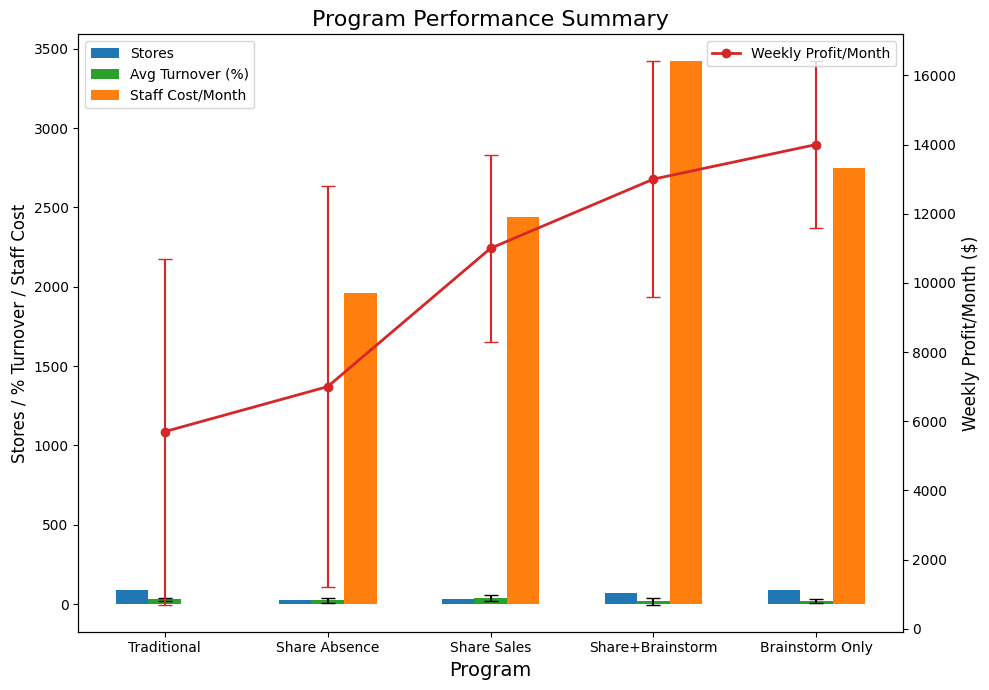

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu từ bảng
programs = ['Traditional', 'Share Absence', 'Share Sales', 'Share+Brainstorm', 'Brainstorm Only']
stores = [89, 27, 35, 67, 87]
avg_turnover = [30, 23, 37, 17, 21]    # (%)
avg_turnover_sd = [10, 14, 20, 20, 12] # SD
weekly_profit = [5700, 7000, 11000, 13000, 14000]   # ($/month)
weekly_profit_sd = [5000, 5800, 2700, 3400, 2400]   # SD
staff_cost = [0, 1960, 2440, 3420, 2750]            # ($/month)

fig, ax1 = plt.subplots(figsize=(10, 7))

x = np.arange(len(programs))
bar_width = 0.2

# Vẽ các biểu đồ cột
bars1 = ax1.bar(x - bar_width, stores, bar_width, label='Stores', color='tab:blue')
bars2 = ax1.bar(x, avg_turnover, bar_width, yerr=avg_turnover_sd, capsize=5, label='Avg Turnover (%)', color='tab:green')
bars3 = ax1.bar(x + bar_width, staff_cost, bar_width, label='Staff Cost/Month', color='tab:orange')

# Vẽ biểu đồ đường cho Lợi nhuận hàng tuần
ax2 = ax1.twinx()
ax2.plot(x, weekly_profit, marker='o', color='tab:red', label='Weekly Profit/Month', linewidth=2)
ax2.errorbar(x, weekly_profit, yerr=weekly_profit_sd, fmt='none', ecolor='tab:red', capsize=5)

# Cài đặt trục và nhãn
plt.xticks(x, programs, fontsize=12)
ax1.set_xlabel('Program', fontsize=14)
ax1.set_ylabel('Stores / % Turnover / Staff Cost', fontsize=12)
ax2.set_ylabel('Weekly Profit/Month ($)', fontsize=12)

# Chú giải
bars = [bars1, bars2, bars3]
labels = [b.get_label() for b in bars]
ax1.legend(bars, labels, loc='upper left')
ax2.legend(loc='upper right')

plt.title('Program Performance Summary', fontsize=16)
plt.tight_layout()
plt.show()


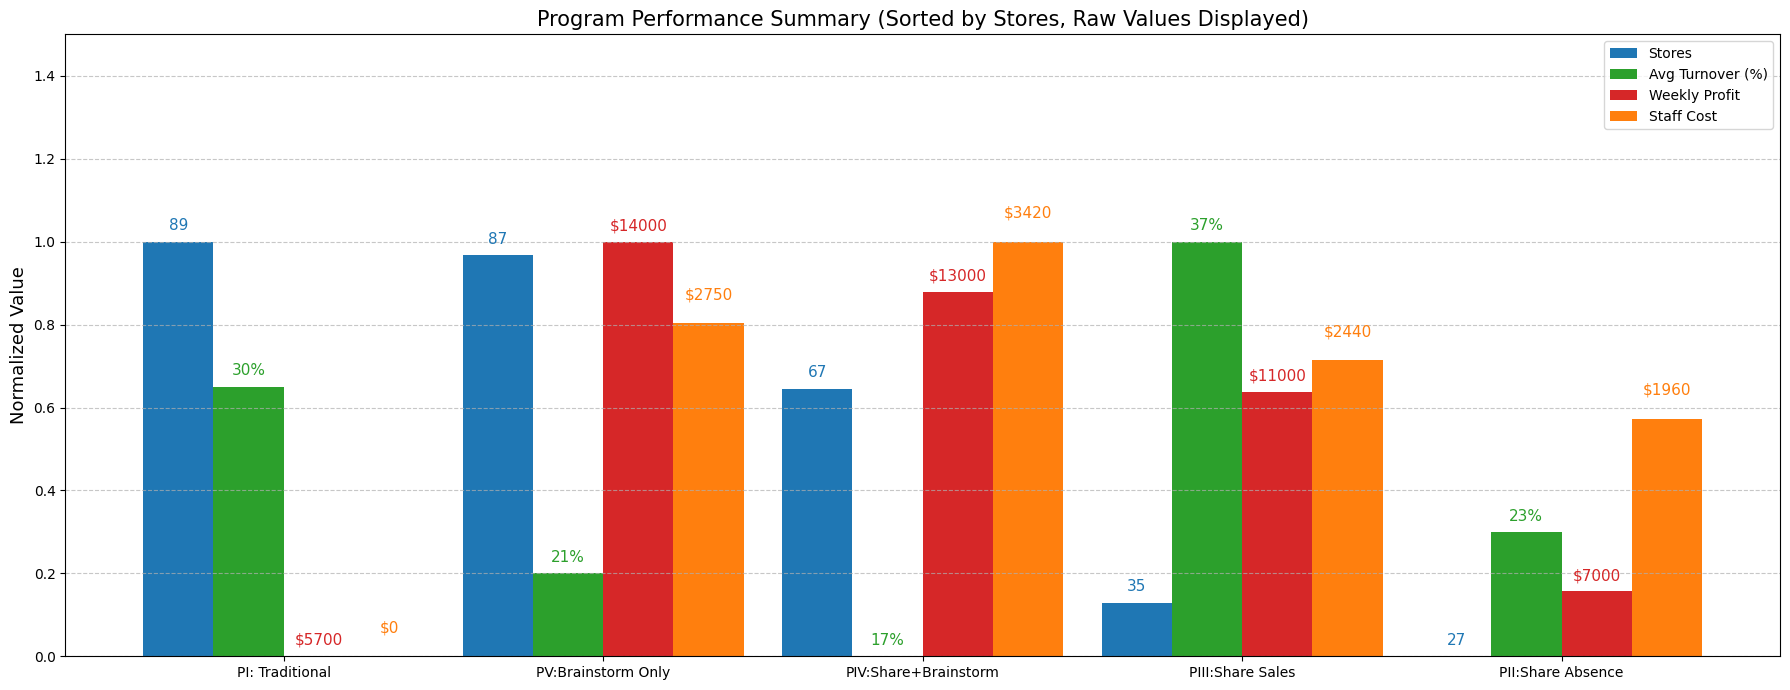

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu gốc từ bảng
programs = np.array(['PI: Traditional', 'PII:Share Absence', 'PIII:Share Sales', 'PIV:Share+Brainstorm', 'PV:Brainstorm Only'])
stores = np.array([89, 27, 35, 67, 87])
avg_turnover = np.array([30, 23, 37, 17, 21])
staff_cost = np.array([0, 1960, 2440, 3420, 2750])
weekly_profit = np.array([5700, 7000, 11000, 13000, 14000])

# Sắp xếp theo stores giảm dần
sorted_idx = np.argsort(-stores)
programs = programs[sorted_idx]
stores = stores[sorted_idx]
avg_turnover = avg_turnover[sorted_idx]
staff_cost = staff_cost[sorted_idx]
weekly_profit = weekly_profit[sorted_idx]

def minmax_scale(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

stores_norm = minmax_scale(stores)
avg_turnover_norm = minmax_scale(avg_turnover)
staff_cost_norm = minmax_scale(staff_cost)
weekly_profit_norm = minmax_scale(weekly_profit)

x = np.arange(len(programs))
bar_width = 0.22

fig, ax = plt.subplots(figsize=(18,7))

# Vẽ bar cho 4 chỉ số chuẩn hóa
bars1 = ax.bar(x - 1.5*bar_width, stores_norm, bar_width, label='Stores', color='tab:blue')
bars2 = ax.bar(x - 0.5*bar_width, avg_turnover_norm, bar_width, label='Avg Turnover (%)', color='tab:green')
bars3 = ax.bar(x + 0.5*bar_width, weekly_profit_norm, bar_width, label='Weekly Profit', color='tab:red')
bars4 = ax.bar(x + 1.5*bar_width, staff_cost_norm, bar_width, label='Staff Cost', color='tab:orange')

# Offset thay đổi giữa các bar cho nhãn không bị đè lên nhau
offsets = [0.02, 0.02, 0.02, 0.05]

for i, rect in enumerate(bars1):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + offsets[0], str(stores[i]),
            ha='center', va='bottom', fontsize=11, color='tab:blue')
for i, rect in enumerate(bars2):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + offsets[1], f"{avg_turnover[i]}%", 
            ha='center', va='bottom', fontsize=11, color='tab:green')
for i, rect in enumerate(bars3):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + offsets[2], f"${weekly_profit[i]}",
            ha='center', va='bottom', fontsize=11, color='tab:red')
for i, rect in enumerate(bars4):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + offsets[3], f"${staff_cost[i]}",
            ha='center', va='bottom', fontsize=11, color='tab:orange')

ax.set_xticks(x)
ax.set_xticklabels(programs)
ax.set_ylabel('Normalized Value', fontsize=13)
ax.set_title('Program Performance Summary (Sorted by Stores, Raw Values Displayed)', fontsize=15)
ax.legend()
plt.ylim(top=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


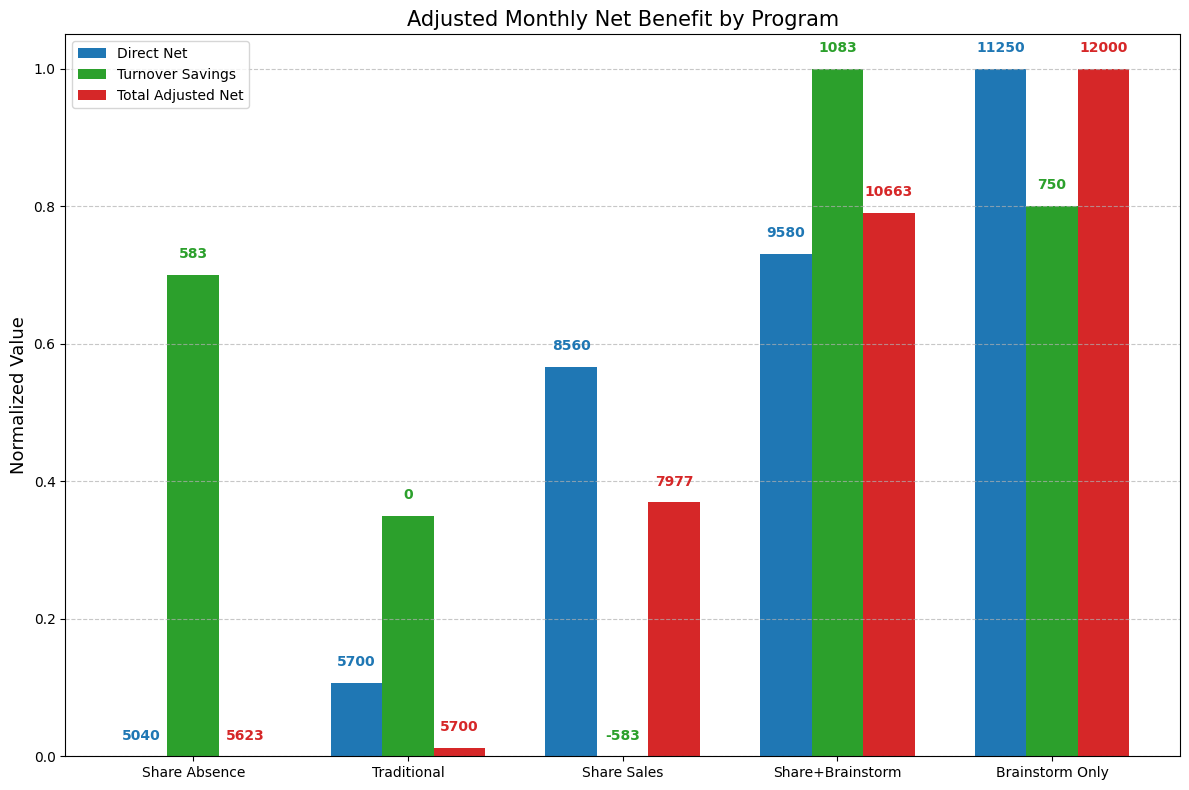

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu từ bảng
programs = np.array(['Traditional', 'Share Absence', 'Share Sales', 'Share+Brainstorm', 'Brainstorm Only'])
direct_net = np.array([5700, 5040, 8560, 9580, 11250])
turnover_savings = np.array([0, 583, -583, 1083, 750])
total_adjusted = np.array([5700, 5623, 7977, 10663, 12000])

# Sắp xếp tăng dần theo total_adjusted
idx_sorted = np.argsort(total_adjusted)
programs = programs[idx_sorted]
direct_net = direct_net[idx_sorted]
turnover_savings = turnover_savings[idx_sorted]
total_adjusted = total_adjusted[idx_sorted]

def minmax_scale(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

direct_net_norm = minmax_scale(direct_net)
turnover_savings_norm = minmax_scale(turnover_savings)
total_adjusted_norm = minmax_scale(total_adjusted)

x = np.arange(len(programs))
bar_width = 0.24
offsets = [0.02, 0.02, 0.02] # Để tránh overlap

fig, ax = plt.subplots(figsize=(12,8))
bars1 = ax.bar(x - bar_width, direct_net_norm, bar_width, label='Direct Net', color='tab:blue')
bars2 = ax.bar(x, turnover_savings_norm, bar_width, label='Turnover Savings', color='tab:green')
bars3 = ax.bar(x + bar_width, total_adjusted_norm, bar_width, label='Total Adjusted Net', color='tab:red')

# Thêm raw value cho mỗi bar
for i, rect in enumerate(bars1):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + offsets[0], f"{direct_net[i]}", ha='center', va='bottom', fontsize=10, color='tab:blue', fontweight='bold')
for i, rect in enumerate(bars2):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + offsets[1], f"{turnover_savings[i]}", ha='center', va='bottom', fontsize=10, color='tab:green', fontweight='bold')
for i, rect in enumerate(bars3):
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + offsets[2], f"{total_adjusted[i]}", ha='center', va='bottom', fontsize=10, color='tab:red', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(programs)
ax.set_ylabel('Normalized Value', fontsize=13)
ax.set_title('Adjusted Monthly Net Benefit by Program', fontsize=15)
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


| Program | Theoretical Alignment                                 | Verdict                                 |
|---------|------------------------------------------------------|-----------------------------------------|
| I       | Violates Self-Determination, Goal-Setting,            | Conflicts with modern OB research       |
|         | Job Characteristics, and Organizational Justice       |                                         |
| II      | Partial Goal-Setting Theory, limited justice,         | Incomplete application of theory        |
|         | misses engagement opportunity                         |                                         |
| III     | **High informational, zero procedural justice,**          | Violates key justice principle          |
|         | **feedback without autonomy (demotivates)**               |                                         |
| IV      | **Aligns with Self-Determination, Goal-Setting,**         | **Excellent theoretical foundation**        |
|         | **Job Characteristics, all justice types**                |                                         |
| V       | Pseudo-participation, incomplete sharing,             | Contradicts authentic participation research |
|         | contract violations likely                            |                                         |


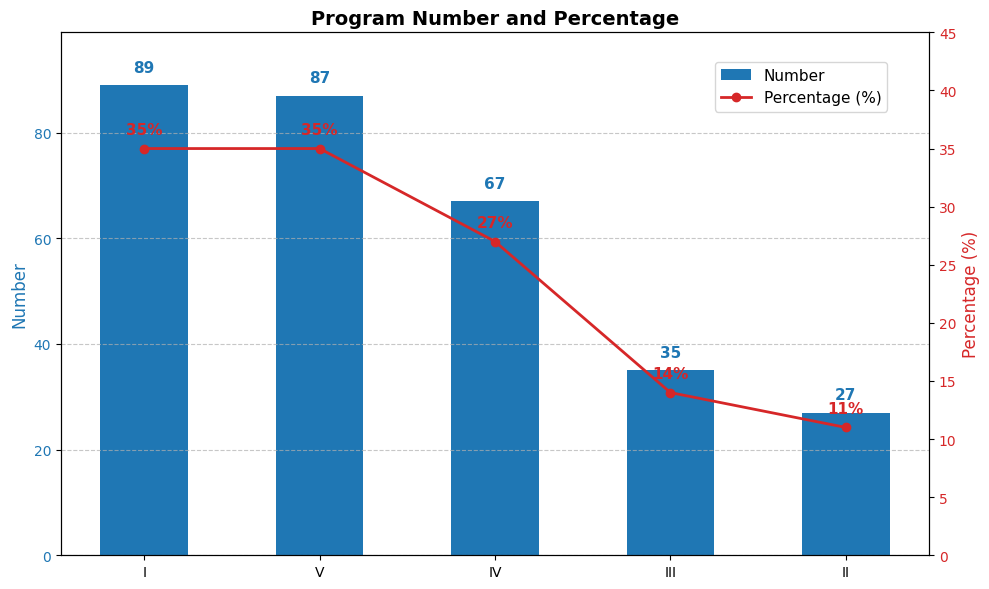

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu
programs = np.array(['I', 'II', 'III', 'IV', 'V'])
numbers = np.array([89, 27, 35, 67, 87])
percentages = np.array([35, 11, 14, 27, 35])

# Sắp xếp theo Number giảm dần
idx_sorted = np.argsort(-numbers)
programs = programs[idx_sorted]
numbers = numbers[idx_sorted]
percentages = percentages[idx_sorted]

x = np.arange(len(programs))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for numbers
bars = ax1.bar(x, numbers, color='tab:blue', width=0.5, label='Number')
ax1.set_ylabel('Number', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, max(numbers) + 10)
for i, rect in enumerate(bars):
    ax1.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 2, f'{numbers[i]}',
             ha='center', va='bottom', fontsize=11, color='tab:blue', fontweight='bold')

# Line plot for percentages on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, percentages, marker='o', color='tab:red', label='Percentage (%)', linewidth=2)
for i, val in enumerate(percentages):
    ax2.text(x[i], val + 1, f'{val}%', ha='center', va='bottom', fontsize=11, color='tab:red', fontweight='bold')
ax2.set_ylabel('Percentage (%)', color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, max(percentages) + 10)

# Add gridlines for better readability
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add title and labels
plt.xticks(x, programs, fontsize=12)
plt.title('Program Number and Percentage', fontsize=14, fontweight='bold')

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9), fontsize=11)

# Adjust layout for better spacing
fig.tight_layout()
plt.show()
